In [1]:
import tensorflow as tf
import numpy as np

In [2]:
(train_images, train_labels), _ = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
print(train_labels.shape) 

(60000, 28, 28)
(60000,)


In [3]:
train_images = train_images / 255.
train_images = tf.reshape(train_images, shape=(train_images.shape[0], 28, 28, 1))
train_images = tf.cast(train_images, dtype=tf.float32)
train_images = tf.concat([train_images, train_images], axis=0)
print(train_images.shape, train_images.dtype)

train_labels = tf.reshape(train_labels, shape=(train_labels.shape[0], 1))
train_labels = tf.cast(train_labels, dtype=tf.int32)
print(train_labels.shape, train_labels.dtype)

train_labels_fake = tf.random.uniform([60000, 1], minval=1, maxval=9, dtype=tf.int32)
train_labels_fake = train_labels + train_labels_fake
train_labels_fake = tf.math.mod(train_labels_fake, 9)
print(train_labels_fake.shape, train_labels_fake.dtype)

train_labels = tf.concat([train_labels, train_labels_fake], axis=0)
print(train_labels.shape, train_labels.dtype)

train_match = tf.concat([tf.ones([60000, 1]), tf.zeros([60000, 1])], axis=0)
print(train_match.shape, train_match.dtype)

(120000, 28, 28, 1) <dtype: 'float32'>
(60000, 1) <dtype: 'int32'>
(60000, 1) <dtype: 'int32'>
(120000, 1) <dtype: 'int32'>
(120000, 1) <dtype: 'float32'>


In [4]:
SAMPLE_SIZE = 16

sample_images = train_images[:SAMPLE_SIZE, :, :, :]
sample_labels = train_labels[:SAMPLE_SIZE]
print(sample_images.shape, sample_labels.shape)

(16, 28, 28, 1) (16, 1)


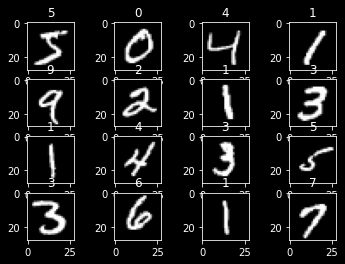

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(sample_labels[i, 0].numpy())
plt.show()

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
RANDOM_SEED = 0

train_images_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE, seed=RANDOM_SEED).repeat(1).batch(BATCH_SIZE, drop_remainder=True)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels).shuffle(BUFFER_SIZE, seed=RANDOM_SEED).repeat(1).batch(BATCH_SIZE, drop_remainder=True)
train_match_dataset = tf.data.Dataset.from_tensor_slices(train_match).shuffle(BUFFER_SIZE, seed=RANDOM_SEED).repeat(1).batch(BATCH_SIZE, drop_remainder=True)

train_dataset = tf.data.Dataset.zip((train_images_dataset, train_labels_dataset, train_match_dataset))

In [7]:
dataset_size = tf.data.experimental.cardinality(train_labels_dataset).numpy()
# dataset_size = len(list(iter(train_labels_dataset)))
dataset_size

468

In [8]:
from model import *

In [9]:
NOISE_DIM = 100

noise = tf.random.normal([SAMPLE_SIZE, NOISE_DIM])

In [10]:
generator = Generator(NOISE_DIM)

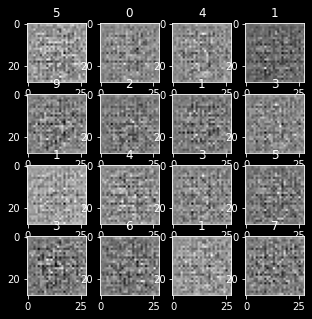

In [11]:
sample_gen_output = generator(sample_labels, noise, training=False)

fig = plt.figure(figsize=(5, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(sample_gen_output[i], cmap='gray')
    ax.set_title(sample_labels[i, 0].numpy())
plt.show()

In [12]:
discriminator = Discriminator()

In [13]:
sample_dis_output = discriminator(sample_labels, sample_gen_output, training=False)
sample_dis_output

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[ 1.1854796 ],
       [-0.31561288],
       [ 0.603981  ],
       [ 0.6021736 ],
       [ 0.5152057 ],
       [-1.8343871 ],
       [-0.6289143 ],
       [ 0.3691433 ],
       [ 0.9364058 ],
       [-0.27068794],
       [ 0.35794115],
       [ 0.38891026],
       [ 0.6796175 ],
       [-0.1403879 ],
       [ 0.7367166 ],
       [ 0.17550725]], dtype=float32)>

In [14]:
def gen_loss(fake_output):
    loss = tf.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True)
    return loss

def dis_loss(real_output, fake_output, matches):
    real_loss = tf.losses.binary_crossentropy(matches, real_output, from_logits=True)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output, from_logits=True)
    return real_loss + fake_loss


In [15]:
gen_optimizer = tf.optimizers.Adam(1e-4)
dis_optimizer = tf.optimizers.Adam(1e-4)

In [16]:
log_dir = 'output'
ckpt_dir = os.path.join(log_dir, 'checkpoint')

In [17]:
ckpt = tf.train.Checkpoint(generator=generator,
                            discriminator=discriminator, 
                            generator_optimizer=gen_optimizer, 
                            discriminator_optimizer=dis_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=10)

In [18]:
EPOCHS = 50
NOISE_DIM = 32
SAMPLE_SIZE = 256

In [19]:
@tf.function
def dis_train_step(images, labels, matches, noise):
    with tf.GradientTape() as dis_tape:
        fake_images = generator(labels, noise, training=False)

        real_output = discriminator(labels, images, training=True)
        fake_output = discriminator(labels, fake_images, training=True)

        dis_l = dis_loss(real_output, fake_output, matches)

    dis_grads = dis_tape.gradient(dis_l, discriminator.trainable_variables)
    dis_optimizer.apply_gradients(zip(dis_grads, discriminator.trainable_variables))

@tf.function
def gen_train_step(labels, noise):
    with tf.GradientTape() as gen_tape:
        fake_images = generator(labels, noise, training=True)

        # real_output = discriminator(labels, images)
        fake_output = discriminator(labels, fake_images, training=False)

        gen_l = gen_loss(fake_output)

    gen_grads = gen_tape.gradient(gen_l, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))

In [20]:
def generate_images(generator, condition, noise=None):
    if noise is None:
        noise = tf.random.normal([condition.shape[0], NOISE_DIM]) 
    generated_images = generator(condition, noise, training=False)

    fig = plt.figure(figsize=(5, 5))
    for i in range(min(16, condition.shape[0])):
        ax = plt.subplot(4, 4, i+1)
        ax.imshow(generated_images[i], cmap='gray')
        ax.set_title(condition[i, 0].numpy())
    plt.show()

In [21]:
generator = Generator(NOISE_DIM)
discriminator = Discriminator()

In [22]:
noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
for _, labels, _ in train_dataset.take(1):
    gen_train_step(labels, noise)

In [23]:
generator.summary()

Model: "generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  640       
_________________________________________________________________
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  8192      
_________________________________________________________________
dense_7 (Dense)              multiple                  10304     
_________________________________________________________________
dense_8 (Dense)              multiple                  802816    
_________________________________________________________________
batch_normalization_3 (Batch multiple                  50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    multiple                  

In [24]:
discriminator.summary()

Model: "discriminator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
flatten_4 (Flatten)          multiple              

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f'epoch: {epoch}')
        dis_probar = tf.keras.utils.Progbar(dataset_size)
        gen_probar = tf.keras.utils.Progbar(dataset_size)

        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        for images, labels, matches in dataset:
            dis_train_step(images, labels, matches, noise)
            dis_probar.add(1)
        
        for _, labels, _ in dataset:
            gen_train_step(labels, noise)
            gen_probar.add(1)
        
        if (epoch+1) % 10 == 0:
            generate_images(generator, sample_labels)

epoch: 0
468/468 [==============================] - 37s 79ms/step
epoch: 1
468/468 [==============================] - 36s 78ms/step
epoch: 2
468/468 [==============================] - 35s 75ms/step
epoch: 3
468/468 [==============================] - 36s 76ms/step
epoch: 4
468/468 [==============================] - 36s 78ms/step
epoch: 5
468/468 [==============================] - 36s 78ms/step
epoch: 6
468/468 [==============================] - 37s 78ms/step
epoch: 7
468/468 [==============================] - 37s 79ms/step
epoch: 8
468/468 [==============================] - 36s 78ms/step
epoch: 9
468/468 [==============================] - 37s 78ms/step


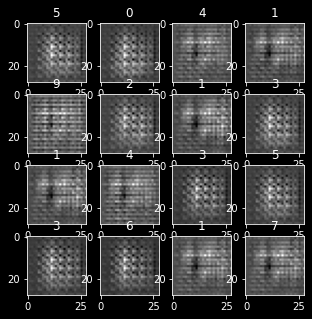

epoch: 10
468/468 [==============================] - 36s 78ms/step
epoch: 11
468/468 [==============================] - 36s 78ms/step
epoch: 12
468/468 [==============================] - 36s 77ms/step
epoch: 13
468/468 [==============================] - 36s 78ms/step
epoch: 14
468/468 [==============================] - 36s 78ms/step
epoch: 15
468/468 [==============================] - 36s 77ms/step
epoch: 16
468/468 [==============================] - 36s 77ms/step
epoch: 17
468/468 [==============================] - 37s 78ms/step
epoch: 18
468/468 [==============================] - 36s 78ms/step
epoch: 19
468/468 [==============================] - 36s 77ms/step


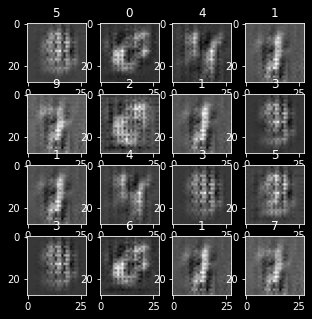

epoch: 20
468/468 [==============================] - 37s 78ms/step
epoch: 21
468/468 [==============================] - 37s 79ms/step
epoch: 22
468/468 [==============================] - 36s 77ms/step
epoch: 23
468/468 [==============================] - 37s 79ms/step
epoch: 24
468/468 [==============================] - 38s 81ms/step
epoch: 25
468/468 [==============================] - 38s 81ms/step
epoch: 26
468/468 [==============================] - 38s 81ms/step
epoch: 27
468/468 [==============================] - 37s 80ms/step
epoch: 28
468/468 [==============================] - 37s 80ms/step
epoch: 29
468/468 [==============================] - 38s 81ms/step


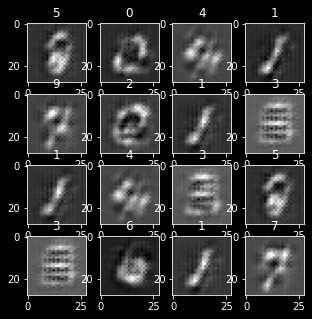

epoch: 30
468/468 [==============================] - 37s 80ms/step
epoch: 31
468/468 [==============================] - 37s 78ms/step
epoch: 32
468/468 [==============================] - 37s 78ms/step
epoch: 33
468/468 [==============================] - 36s 78ms/step
epoch: 34
468/468 [==============================] - 37s 78ms/step
epoch: 35
468/468 [==============================] - 37s 79ms/step
epoch: 36
468/468 [==============================] - 37s 78ms/step
epoch: 37
468/468 [==============================] - 37s 80ms/step
epoch: 38
468/468 [==============================] - 38s 81ms/step
epoch: 39
468/468 [==============================] - 37s 79ms/step


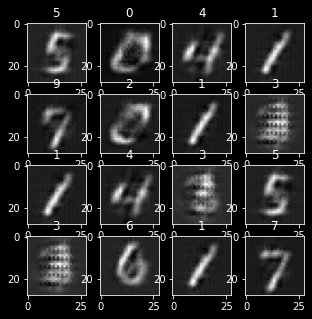

epoch: 40
468/468 [==============================] - 37s 79ms/step
epoch: 41
468/468 [==============================] - 37s 78ms/step
epoch: 42
468/468 [==============================] - 37s 79ms/step
epoch: 43
468/468 [==============================] - 37s 79ms/step
epoch: 44
468/468 [==============================] - 37s 79ms/step
epoch: 45
468/468 [==============================] - 37s 78ms/step
epoch: 46
468/468 [==============================] - 37s 79ms/step
epoch: 47
468/468 [==============================] - 37s 78ms/step
epoch: 48
468/468 [==============================] - 37s 78ms/step
epoch: 49
468/468 [==============================] - 37s 79ms/step


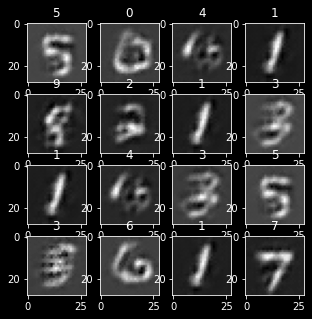

In [26]:
train(train_dataset, EPOCHS)